# experiments with DuckDB and geoparquet

This notebook explores the possibility of working with the SnowEx data in geoparquet format rather than using a PostgreSQL database. The advantage of this approach would be that we could host the data on S3 without the need for a persistent database management service.

## Links:

* [DuckDB](https://duckdb.org/)
* [geoparquet](https://geoparquet.org/)
* [geoparquet tutorials](https://github.com/cholmes/duckdb-geoparquet-tutorials)
* [duckdb spatial mapping](https://www.google.com/search?q=duckdb+plot+spatial&oq=duckdb+plot+spatial&gs_lcrp=EgZjaHJvbWUyBggAEEUYOTIKCAEQABiABBiiBDIKCAIQABiABBiiBDIKCAMQABiABBiiBDIKCAQQABiABBiiBDIKCAUQABiABBiiBNIBCDMyNTNqMGoxqAIAsAIA&sourceid=chrome&ie=UTF-8#fpstate=ive&vld=cid:75dcf93e,vid:r3A_OLT-JBM,st:0)


## Converting from postgresql

As an initial test, let's convert one of the main snowexsql database tables to geoparquet (the 'points' table). Then we can compare query times with our existing API.

To do this I followed the steps in [this documentation](https://www.crunchydata.com/blog/parquet-and-postgres-in-the-data-lake).

Details:
* ```mamba install conda-forge::gdal```
* ```mamba install -c conda-forge libgdal-pg```
* ```mamba install -c conda-forge libdgal-arrow-parquet```
* ``` ogr2ogr -f Parquet /tmp/points.parquet PG:"dbname='snowex' host='db.snowexdata.org' port='5432' user='snow' password='hackweek'" points```

Next I uploaded the points.parquet file to an S3 bucket and acquired a security key for accessing the file.

In [1]:
#!pip install geoparquet # this is not yet on cryocloud
#!pip install python-dotenv
import duckdb
import pandas as pd
import geopandas as gpd
import geoparquet as gpq
from dotenv import load_dotenv
from snowexsql.api import PointMeasurements
import os
from dotenv import dotenv_values

import matplotlib.pyplot as plt
import contextily as ctx 

### Enable the AWS and httpfs extensions in duckdb

In [2]:
con = duckdb.connect()
con.install_extension("httpfs")
con.load_extension("httpfs")
con.install_extension("aws")
con.load_extension("aws")

In [3]:
load_dotenv() # credentials come from a local .env file
k=os.getenv('KEY_ID')
s=os.getenv('SECRET')

In [4]:
duckdb.sql("""CREATE SECRET (TYPE S3,KEY_ID {}, SECRET {}, REGION 'us-west-2')""".format(k,s))

┌─────────┐
│ Success │
│ boolean │
├─────────┤
│ true    │
└─────────┘

### Try showing all the columns of the database

In [5]:
duckdb.sql("DESCRIBE SELECT * FROM read_parquet('s3://snowexdb/points.parquet')")

┌────────────────┬────────────────────────────────────────────────────────┬─────────┬─────────┬─────────┬─────────┐
│  column_name   │                      column_type                       │  null   │   key   │ default │  extra  │
│    varchar     │                        varchar                         │ varchar │ varchar │ varchar │ varchar │
├────────────────┼────────────────────────────────────────────────────────┼─────────┼─────────┼─────────┼─────────┤
│ id             │ BIGINT                                                 │ YES     │ NULL    │ NULL    │ NULL    │
│ site_name      │ VARCHAR                                                │ YES     │ NULL    │ NULL    │ NULL    │
│ date           │ DATE                                                   │ YES     │ NULL    │ NULL    │ NULL    │
│ time_created   │ TIMESTAMP WITH TIME ZONE                               │ YES     │ NULL    │ NULL    │ NULL    │
│ time_updated   │ TIMESTAMP                                            

## Simple query to replicate the first example in the db tutorial

In [6]:
df = duckdb.sql("SELECT value, longitude, latitude FROM read_parquet('s3://snowexdb/points.parquet') WHERE type='depth' AND instrument='pit ruler' LIMIT 100").to_df()

In [12]:
# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df, 
    geometry=gpd.points_from_xy(df.longitude, df.latitude)
)

# Set the coordinate reference system (CRS) if needed
gdf.set_crs(epsg=4326, inplace=True)

value  longitude  latitude                     geometry
0    83.0 -108.06311  39.04496  POINT (-108.06311 39.04496)
1   100.0 -108.19593  39.04563  POINT (-108.19593 39.04563)
2   117.0 -108.14791  39.00760   POINT (-108.14791 39.0076)
3    98.0 -108.16401  39.02144  POINT (-108.16401 39.02144)
4    92.0 -108.19103  39.03404  POINT (-108.19103 39.03404)
..    ...        ...       ...                          ...
95   92.0 -108.20975  39.03596  POINT (-108.20975 39.03596)
96   35.0 -108.18948  39.03126  POINT (-108.18948 39.03126)
97  101.0 -108.15596  39.01843  POINT (-108.15596 39.01843)
98  102.0 -108.14158  39.01437  POINT (-108.14158 39.01437)
99  115.0 -108.00313  39.03918  POINT (-108.00313 39.03918)

[100 rows x 4 columns]

In [13]:
gdf.explore()

# Experimenting with duckdb queries:

In [21]:
df = duckdb.sql("SELECT value, latitude, longitude FROM read_parquet('s3://snowexdb/layers.parquet') WHERE type='specific_surface_area'").to_df()

In [22]:
# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df, 
    geometry=gpd.points_from_xy(df.longitude, df.latitude)
)

# Set the coordinate reference system (CRS) if needed
gdf.set_crs(epsg=4326, inplace=True)

value   latitude   longitude                     geometry
0     36.0  39.053236 -108.200765  POINT (-108.20076 39.05324)
1     27.1  39.053236 -108.200765  POINT (-108.20076 39.05324)
2     24.3  39.053236 -108.200765  POINT (-108.20076 39.05324)
3     21.0  39.053236 -108.200765  POINT (-108.20076 39.05324)
4     20.7  39.053236 -108.200765  POINT (-108.20076 39.05324)
...    ...        ...         ...                          ...
2169  12.1  39.029403 -108.145964   POINT (-108.14596 39.0294)
2170  12.6  39.029403 -108.145964   POINT (-108.14596 39.0294)
2171  10.0  39.029403 -108.145964   POINT (-108.14596 39.0294)
2172  11.0  39.029403 -108.145964   POINT (-108.14596 39.0294)
2173  10.5  39.029403 -108.145964   POINT (-108.14596 39.0294)

[2174 rows x 4 columns]

In [23]:
gdf.explore()

In [13]:
# What are the unique instruments used at Grand Mesa for all years?
df = duckdb.sql("SELECT DISTINCT instrument \
                 FROM read_parquet('s3://snowexdb/points.parquet') \
                 WHERE site_name = 'Grand Mesa'").to_df()
print(df)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

                                    instrument
0  pulse EKKO Pro multi-polarization 1 GHz GPR
1                                   magnaprobe
2                                         mesa
3                            Mala 1600 MHz GPR
4                                    pit ruler
5                                       camera
6                             Mala 800 MHz GPR


In [14]:
# What years were GPR data collected at Grand Mesa?

df = duckdb.sql("SELECT DISTINCT EXTRACT(YEAR FROM date) AS year \
                 FROM read_parquet('s3://snowexdb/points.parquet') \
                 WHERE site_name = 'Grand Mesa' \
                 AND instrument LIKE '%GPR%'").to_df()
print(df)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   year
0  2020


In [6]:
# Selecting all entries at Grand Mesa where GPR was collected

df = duckdb.sql("SELECT value, latitude, longitude, observers, instrument \
                 FROM read_parquet('s3://snowexdb/points.parquet') \
                 WHERE site_name = 'Grand Mesa' \
                 AND instrument LIKE '%GPR%'").to_df()

print(df)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

             value   latitude   longitude        observers  \
0        87.566026  39.019223 -108.174896  Randall Bonnell   
1        89.067154  39.019224 -108.174893  Randall Bonnell   
2        91.068661  39.019224 -108.174889  Randall Bonnell   
3        91.569041  39.019224 -108.174886  Randall Bonnell   
4        93.070168  39.019224 -108.174883  Randall Bonnell   
...            ...        ...         ...              ...   
6889531  86.565266  39.019222 -108.174914  Randall Bonnell   
6889532  86.565266  39.019222 -108.174910  Randall Bonnell   
6889533  87.065646  39.019222 -108.174907  Randall Bonnell   
6889534  87.566026  39.019223 -108.174903  Randall Bonnell   
6889535  86.565266  39.019223 -108.174900  Randall Bonnell   

                                          instrument  
0        pulse EKKO Pro multi-polarization 1 GHz GPR  
1        pulse EKKO Pro multi-polarization 1 GHz GPR  
2        pulse EKKO Pro multi-polarization 1 GHz GPR  
3        pulse EKKO Pro multi-polar

In [7]:
# # Query where we're selecting all entries in 2020 at Grand Mesa, Ryan and Randall
# df = duckdb.sql("SELECT value, latitude, longitude, equipment, observers, type, \
#                        instrument, site_name, geom, site_id, date, id \
#                  FROM read_parquet('s3://snowexdb/points.parquet') \
#                  WHERE site_name = 'Grand Mesa' \
#                  AND date BETWEEN '2020-01-01' AND '2020-12-31' \
#                  AND observers IN ('Randall Bonnell', 'Ryan Webb')").to_df()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [7]:
# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df, 
    geometry=gpd.points_from_xy(df.longitude, df.latitude)
)

# Set the coordinate reference system (CRS) if needed
gdf.set_crs(epsg=4326, inplace=True)

value   latitude   longitude        observers  \
0        87.566026  39.019223 -108.174896  Randall Bonnell   
1        89.067154  39.019224 -108.174893  Randall Bonnell   
2        91.068661  39.019224 -108.174889  Randall Bonnell   
3        91.569041  39.019224 -108.174886  Randall Bonnell   
4        93.070168  39.019224 -108.174883  Randall Bonnell   
...            ...        ...         ...              ...   
6889531  86.565266  39.019222 -108.174914  Randall Bonnell   
6889532  86.565266  39.019222 -108.174910  Randall Bonnell   
6889533  87.065646  39.019222 -108.174907  Randall Bonnell   
6889534  87.566026  39.019223 -108.174903  Randall Bonnell   
6889535  86.565266  39.019223 -108.174900  Randall Bonnell   

                                          instrument  \
0        pulse EKKO Pro multi-polarization 1 GHz GPR   
1        pulse EKKO Pro multi-polarization 1 GHz GPR   
2        pulse EKKO Pro multi-polarization 1 GHz GPR   
3        pulse EKKO Pro multi-polarization 1 GHz GPR   
4        pulse EKKO Pro multi-polarization 1 GHz GPR   
...                                              ...   
6889531  pulse EKKO Pro multi-polarization 1 GHz GPR   
6889532  pulse EKKO Pro multi-polarization 1 GHz GPR   
6889533  pulse EKKO Pro multi-polarization 1 GHz GPR   
6889534  pulse EKKO Pro multi-polarization 1 GHz GPR   
6889535  pulse EKKO Pro multi-polarization 1 GHz GPR   

                            geometry  
0         POINT (-108.1749 39.01922)  
1        POINT (-108.17489 39.01922)  
2        POINT (-108.17489 39.01922)  
3        POINT (-108.17489 39.01922)  
4        POINT (-108.17488 39.01922)  
...                              ...  
6889531  POINT (-108.17491 39.01922)  
6889532  POINT (-108.17491 39.01922)  
6889533  POINT (-108.17491 39.01922)  
6889534   POINT (-108.1749 39.01922)  
6889535   POINT (-108.1749 39.01922)  

[6889536 rows x 6 columns]

# Experimenting with plotting/mapping with duckdb/geoparquet versus with the snowex_sql API:

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.72 µs


/srv/conda/envs/notebook/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


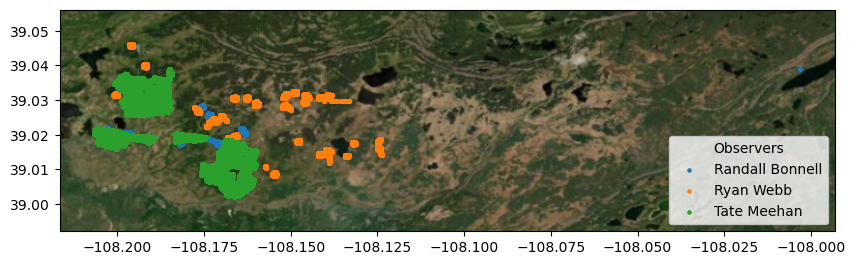

In [8]:
# Plotting GPR observations for Grand Mesa, all years and all observers

import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx 

# Group by observer
observers = gdf['observers'].unique()

# Start timing
%time

# Plot the points, colored by observer
fig, ax = plt.subplots(figsize=(10, 10))
for observer in observers:
    subset = gdf[gdf['observers'] == observer]
    subset.plot(ax=ax, label=observer, markersize=5, alpha=0.6)

# Set aspect ratio to 'equal' to ensure points fit in map
ax.set_aspect('equal')

# Set plot limits with a small margin around the points
margin = 0.01
bounds = gdf.total_bounds
ax.set_xlim(bounds[0] - margin, bounds[2] + margin)
ax.set_ylim(bounds[1] - margin, bounds[3] + margin)

# Add the basemap - can change from ESRI if needed
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.Esri.WorldImagery, attribution = False)

# Add legend
plt.legend(title='Observers')
plt.show()

In [ ]:
# This plot took minutes to make...

In [35]:
# Query something smaller than GPR...

# Looking at Magnaprobe in Grand Mesa instead
df = duckdb.sql("SELECT value, latitude, longitude, observers, instrument \
                 FROM read_parquet('s3://snowexdb/points.parquet') \
                 WHERE site_name = 'Grand Mesa' \
                 AND instrument = 'magnaprobe'").to_df()

In [36]:
# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df, 
    geometry=gpd.points_from_xy(df.longitude, df.latitude)
)

# Set the coordinate reference system (CRS) if needed
gdf.set_crs(epsg=4326, inplace=True)

value  latitude  longitude observers  instrument  \
0       94.0  39.03045 -108.13515      None  magnaprobe   
1       74.0  39.03045 -108.13516      None  magnaprobe   
2       90.0  39.03045 -108.13517      None  magnaprobe   
3       87.0  39.03044 -108.13519      None  magnaprobe   
4       90.0  39.03042 -108.13519      None  magnaprobe   
...      ...       ...        ...       ...         ...   
33359  112.0  39.03035 -108.17213      None  magnaprobe   
33360  104.0  39.03032 -108.17214      None  magnaprobe   
33361  107.0  39.03029 -108.17214      None  magnaprobe   
33362   94.0  39.03028 -108.17211      None  magnaprobe   
33363  106.0  39.03025 -108.17210      None  magnaprobe   

                          geometry  
0      POINT (-108.13515 39.03045)  
1      POINT (-108.13516 39.03045)  
2      POINT (-108.13517 39.03045)  
3      POINT (-108.13519 39.03044)  
4      POINT (-108.13519 39.03042)  
...                            ...  
33359  POINT (-108.17213 39.03035)  
33360  POINT (-108.17214 39.03032)  
33361  POINT (-108.17214 39.03029)  
33362  POINT (-108.17211 39.03028)  
33363   POINT (-108.1721 39.03025)  

[33364 rows x 6 columns]

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs


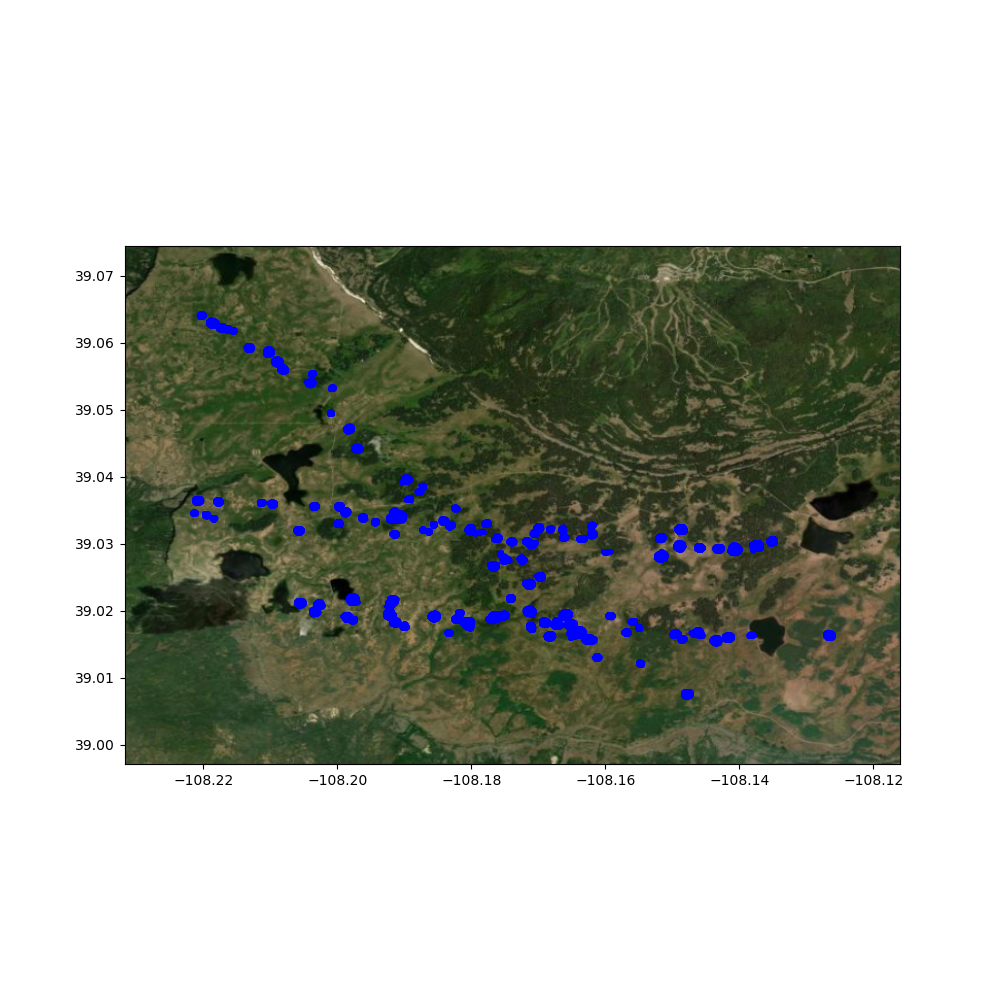

In [37]:
%matplotlib notebook
# make plot interactive!

# Plot magnaprobe observations
fig, ax = plt.subplots(figsize=(10, 10))

%time

# Plot the points
gdf.plot(ax=ax, markersize=5, alpha=0.7, color='blue')

# Set aspect ratio to equal
ax.set_aspect('equal')

# Set plot limits with a small margin around the points
margin = 0.01
bounds = gdf.total_bounds
ax.set_xlim(bounds[0] - margin, bounds[2] + margin)
ax.set_ylim(bounds[1] - margin, bounds[3] + margin)

# Add the basemap
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.Esri.WorldImagery, attribution=False)

# Remove legend
ax.legend_.remove() if ax.legend_ else None

plt.show()


In [ ]:
# This took seconds... it seems like the GPR datasets are just huge and plotting all of them at once causes it to take minutes

In [6]:
# Selecting both magnaprobe and pit locations (using pit ruler instrument)
df = duckdb.sql("SELECT value, latitude, longitude, observers, instrument \
                 FROM read_parquet('s3://snowexdb/points.parquet') \
                 WHERE site_name = 'Grand Mesa' \
                 AND instrument IN ('magnaprobe', 'pit ruler')").to_df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [7]:
# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df, 
    geometry=gpd.points_from_xy(df.longitude, df.latitude)
)

# Set the coordinate reference system (CRS) if needed
gdf.set_crs(epsg=4326, inplace=True)

value  latitude  longitude observers  instrument  \
0       94.0  39.03045 -108.13515      None  magnaprobe   
1       74.0  39.03045 -108.13516      None  magnaprobe   
2       90.0  39.03045 -108.13517      None  magnaprobe   
3       87.0  39.03044 -108.13519      None  magnaprobe   
4       90.0  39.03042 -108.13519      None  magnaprobe   
...      ...       ...        ...       ...         ...   
33526  110.0  39.01801 -108.16532      None   pit ruler   
33527  139.0  39.01846 -108.18073      None   pit ruler   
33528   88.0  39.03618 -108.21137      None   pit ruler   
33529  104.0  39.01926 -108.15929      None   pit ruler   
33530  107.0  39.03341 -108.18423      None   pit ruler   

                          geometry  
0      POINT (-108.13515 39.03045)  
1      POINT (-108.13516 39.03045)  
2      POINT (-108.13517 39.03045)  
3      POINT (-108.13519 39.03044)  
4      POINT (-108.13519 39.03042)  
...                            ...  
33526  POINT (-108.16532 39.01801)  
33527  POINT (-108.18073 39.01846)  
33528  POINT (-108.21137 39.03618)  
33529  POINT (-108.15929 39.01926)  
33530  POINT (-108.18423 39.03341)  

[33531 rows x 6 columns]

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


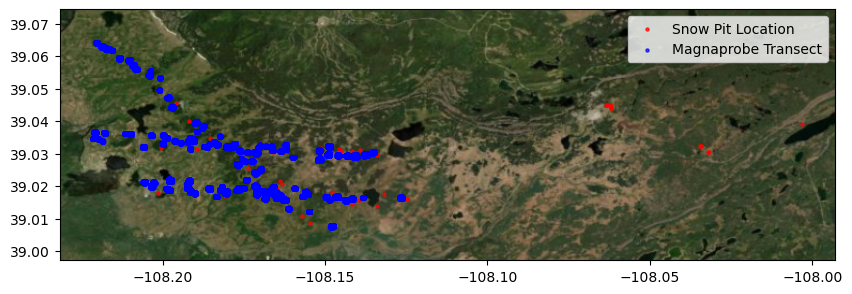

In [8]:
# Plotting pit locations and magnaprobe  - with duckdb gdf
import matplotlib.pyplot as plt

# %matplotlib notebook
# uncomment ^ for interactive plot

%time # timing

fig, ax = plt.subplots(figsize=(10, 10))

# Plot Snow Pit Locations
gdf_pit_ruler = gdf[gdf['instrument'] == 'pit ruler']
gdf_pit_ruler.plot(ax=ax, markersize=5, alpha=0.7, color='red', label='Snow Pit Location')

# Plot Magnaprobe Locations
gdf_magnaprobe = gdf[gdf['instrument'] == 'magnaprobe']
gdf_magnaprobe.plot(ax=ax, markersize=5, alpha=0.7, color='blue', label='Magnaprobe Transect')

# Set aspect ratio to 'equal'
ax.set_aspect('equal')

# Set plot limits with a small margin around the points
margin = 0.01
bounds = gdf.total_bounds
ax.set_xlim(bounds[0] - margin, bounds[2] + margin)
ax.set_ylim(bounds[1] - margin, bounds[3] + margin)

# Add the basemap without credits
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.Esri.WorldImagery, attribution=False)

# Add legend
plt.legend()

plt.show()

In [ ]:
# Let's compare time it takes for duckdb to plot magnaprobe/pits versus snowex_sql api
# This would probably be of interest for the NSIDC mapping group...

In [9]:
from snowexsql.api import PointMeasurements as pt_measurements

# make object with pits and magnaprobe
instruments_ofinterest = ["magnaprobe", "pit ruler"]

df = pt_measurements.from_filter(
    instrument= instruments_ofinterest,
    site_name="Grand Mesa",
    limit = 40000
)

In [10]:
# Make it a GDF..
gdf = gpd.GeoDataFrame(
    df, 
    geometry=gpd.points_from_xy(df.longitude, df.latitude)
)

# Set the coordinate reference system (CRS) if needed
gdf.set_crs(epsg=4326, inplace=True)

version_number equipment  value  latitude  longitude      northing  \
0                   1   CRREL_B   94.0  39.03045 -108.13515  4.324062e+06   
1                   1   CRREL_B   74.0  39.03045 -108.13516  4.324062e+06   
2                   1   CRREL_B   90.0  39.03045 -108.13517  4.324062e+06   
3                   1   CRREL_B   87.0  39.03044 -108.13519  4.324060e+06   
4                   1   CRREL_B   90.0  39.03042 -108.13519  4.324058e+06   
...               ...       ...    ...       ...        ...           ...   
33526               1   CRREL_A  105.0  39.01593 -108.14196  4.322431e+06   
33527               1   CRREL_A  106.0  39.01590 -108.14192  4.322428e+06   
33528               1   CRREL_A   97.0  39.01588 -108.14188  4.322426e+06   
33529               1   CRREL_A  100.0  39.01586 -108.14183  4.322424e+06   
33530               1   CRREL_A  100.0  39.01585 -108.14181  4.322423e+06   

             easting  elevation  utm_zone                            geom  \
0      747987.619062     3148.2        12  POINT (747987.619 4324061.706)   
1      747986.753289     3148.3        12  POINT (747986.753 4324061.679)   
2      747985.887517     3148.2        12  POINT (747985.888 4324061.652)   
3      747984.190953     3148.6        12  POINT (747984.191 4324060.487)   
4      747984.260913     3150.1        12  POINT (747984.261 4324058.267)   
...              ...        ...       ...                             ...   
33526  747448.691281     3108.6        12  POINT (747448.691 4322431.423)   
33527  747452.259736     3107.9        12   POINT (747452.26 4322428.201)   
33528  747455.793307     3108.4        12   POINT (747455.793 4322426.09)   
33529  747460.192830     3108.1        12  POINT (747460.193 4322424.006)   
33530  747461.959617     3108.2        12   POINT (747461.96 4322422.951)   

       ...                     time_created time_updated     id  \
0      ... 2022-06-30 22:56:52.635035+00:00         None   4070   
1      ... 2022-06-30 22:56:52.635035+00:00         None   4071   
2      ... 2022-06-30 22:56:52.635035+00:00         None   4072   
3      ... 2022-06-30 22:56:52.635035+00:00         None   4073   
4      ... 2022-06-30 22:56:52.635035+00:00         None   4074   
...    ...                              ...          ...    ...   
33526  ... 2022-06-30 22:56:52.635035+00:00         None  20852   
33527  ... 2022-06-30 22:56:52.635035+00:00         None  20853   
33528  ... 2022-06-30 22:56:52.635035+00:00         None  20854   
33529  ... 2022-06-30 22:56:52.635035+00:00         None  20855   
33530  ... 2022-06-30 22:56:52.635035+00:00         None  20856   

                                        doi date_accessed  instrument   type  \
0      https://doi.org/10.5067/9IA978JIACAR    2022-06-30  magnaprobe  depth   
1      https://doi.org/10.5067/9IA978JIACAR    2022-06-30  magnaprobe  depth   
2      https://doi.org/10.5067/9IA978JIACAR    2022-06-30  magnaprobe  depth   
3      https://doi.org/10.5067/9IA978JIACAR    2022-06-30  magnaprobe  depth   
4      https://doi.org/10.5067/9IA978JIACAR    2022-06-30  magnaprobe  depth   
...                                     ...           ...         ...    ...   
33526  https://doi.org/10.5067/9IA978JIACAR    2022-06-30  magnaprobe  depth   
33527  https://doi.org/10.5067/9IA978JIACAR    2022-06-30  magnaprobe  depth   
33528  https://doi.org/10.5067/9IA978JIACAR    2022-06-30  magnaprobe  depth   
33529  https://doi.org/10.5067/9IA978JIACAR    2022-06-30  magnaprobe  depth   
33530  https://doi.org/10.5067/9IA978JIACAR    2022-06-30  magnaprobe  depth   

      units observers                     geometry  
0        cm      None  POINT (-108.13515 39.03045)  
1        cm      None  POINT (-108.13516 39.03045)  
2        cm      None  POINT (-108.13517 39.03045)  
3        cm      None  POINT (-108.13519 39.03044)  
4        cm      None  POINT (-108.13519 39.03042)  
...     ...       ...                          ...  
33526    cm      Non

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


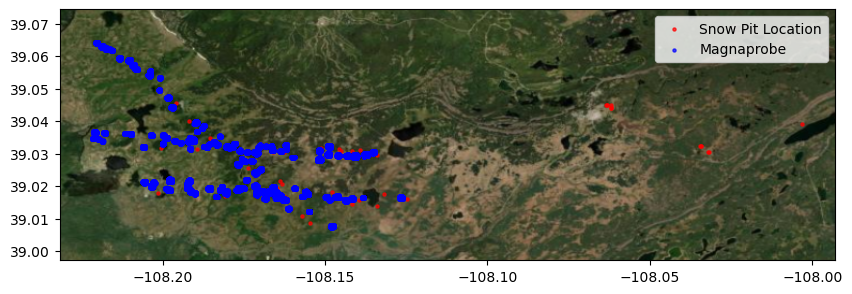

In [11]:
# Plot:

# %matplotlib notebook
# uncomment ^ for interactive plot

%time # timing

fig, ax = plt.subplots(figsize=(10, 10))

# Plot Snow Pit Locations
gdf_pit_ruler = gdf[gdf['instrument'] == 'pit ruler']
gdf_pit_ruler.plot(ax=ax, markersize=5, alpha=0.7, color='red', label='Snow Pit Location')

# Plot Magnaprobe Locations
gdf_magnaprobe = gdf[gdf['instrument'] == 'magnaprobe']
gdf_magnaprobe.plot(ax=ax, markersize=5, alpha=0.7, color='blue', label='Magnaprobe')

# Set aspect ratio to 'equal'
ax.set_aspect('equal')

# Set plot limits with a small margin around the points
margin = 0.01
bounds = gdf.total_bounds
ax.set_xlim(bounds[0] - margin, bounds[2] + margin)
ax.set_ylim(bounds[1] - margin, bounds[3] + margin)

# Add the basemap without credits
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.Esri.WorldImagery, attribution=False)

# Add legend without title
plt.legend()

plt.show()

In [ ]:
# The timing of the magnaprobe/pit plots for both the API and duckdb are really similar - within tens of a milisecond

# Worth noting that GPR points were not tested/plotted using the API...